In [1]:
%load_ext autoreload
%autoreload 2

# Imports and Setup

In [12]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import scipy
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns # v 0.11.0
import os
import h5py
import numpy as np
from astropy import units as u, constants as const
import healpy as hp

In [3]:
###### # Setup Plotting Defaults #
###################################### ##
# For more options see https://matplotlib.org/users/customizing.html

from cycler import cycler

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.epi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 16, 8

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

mpl.rcParams['text.usetex'] = True 

# Estimate Backgrounds

- stack data
- download data from github
- remove instrumental and isotropic background by getting background rings, with exposure time, then rescaling to signal region and subtracting
    - account for updated exposure time 
    - 26 years instead of 19 years, but would need to see if XMM-Newton is still taking exposures at the same rate
    - another instrumental background: quiescent particle background
- how to get galactic astrophysical backgrounds?
    - since this is a line search, 2102.02207 did GP modeling of continous background
    - astrophysical line backgrounds come from AtomDB database + additional Fe lines
- 

# Make D-factor Map

In [9]:
# MW_Vcirc = np.loadtxt('/global/cfs/cdirs/m3166/kraman/Mega_Decaying_DM_Milkyway_Analysis/data/MW_Vcirc.csv', delimiter=',')
# r = MW_Vcirc[:,0] * u.kpc
# vcirc = (MW_Vcirc[:,1] * u.km / u.s).to(u.kpc / u.Gyr)
# enclosedMass = (vcirc**2 * r * const.G**(-1)).to(u.Msun)

# # Calculate dM/dr using numerical differentiation
# dM_dr = np.gradient(enclosedMass.value, r.value) * (enclosedMass.unit / r.unit)

# # Compute density
# density = dM_dr / (4 * np.pi * r**2)

# # Convert to appropriate units (e.g., Msun/kpc^3)
# density = density.to(u.Msun / u.kpc**3)

r = np.logspace(-2, 2, 100) * u.kpc
rhos = 6.6e6 * u.Msun / u.kpc**3
rs = 19.1 * u.kpc
density = rhos / ((r / rs) * (1 + r / rs)**2)


In [10]:
# from scipy.optimize import curve_fit

# # Define power law function: ρ(r) = ρ₀ * (r/r₀)^α
# def power_law(r, rho0, alpha):
#     return rho0 * r**alpha

# # Select inner region for fitting (e.g., innermost points)
# # Adjust n_inner based on your data (typically 5-10 points)
# n_inner = 5
# r_inner = r[:n_inner].value
# density_inner = density[:n_inner].value

# # Fit power law to inner region (in log space for better fit)
# def log_power_law(log_r, log_rho0, alpha):
#     return log_rho0 + alpha * log_r

# popt, pcov = curve_fit(log_power_law, np.log(r_inner), np.log(density_inner))
# log_rho0_fit, alpha_fit = popt

# print(f"Power law index α = {alpha_fit:.3f}")
# print(f"ρ₀ at r=1 kpc: {np.exp(log_rho0_fit):.3e} Msun/kpc^3")

# # Create extended radial grid from 0.1 kpc to original range
# r_min = 0.1  # kpc
# r_extended = np.logspace(np.log10(r_min), np.log10(r.value[-1]), 100)

# # Compute extended density profile
# # Use power law for r < r[n_inner], original data for r >= r[n_inner]
# density_extended = np.zeros(len(r_extended))

# for i, r_val in enumerate(r_extended):
#     if r_val < r_inner[-1]:
#         # Use fitted power law
#         density_extended[i] = np.exp(log_rho0_fit) * r_val**alpha_fit
#     else:
#         # Interpolate from original density profile
#         density_extended[i] = np.interp(r_val, r.value, density.value)

# # Add units
# r_extended = r_extended * u.kpc
# density_extended = density_extended * density.unit

In [11]:
# D-factor calculation: D(ψ) = ∫ ρ(r(s,ψ)) ds
# where s is the line-of-sight distance, ψ is the angle from Galactic center
# and r(s,ψ) = √(s² + r_sun² - 2*s*r_sun*cos(ψ)) for spherical symmetry

# Solar position
r_sun = 8. * u.kpc  # Distance from Galactic center to Sun

# Create interpolation function for density
from scipy.interpolate import interp1d
# density_interp = interp1d(r_extended.value, density_extended.value, 
#                           kind='linear', bounds_error=False, fill_value=0)

density_interp = interp1d(r.value, density.value, 
                          kind='linear', bounds_error=False, fill_value=0)

def los_distance(s, psi, r_sun_val):
    """
    Compute galactocentric distance for a point at line-of-sight distance s
    and angle ψ from the Galactic center direction (law of cosines)
    """
    return np.sqrt(s**2 + r_sun_val**2 - 2*s*r_sun_val*np.cos(psi))

def compute_D_factor(psi, r_sun_val, s_max=100):
    """
    Compute D-factor for a given angle ψ from Galactic center
    
    Parameters:
    -----------
    psi : float
        Angle from Galactic center (radians)
    r_sun_val : float
        Solar galactocentric distance (kpc)
    s_max : float
        Maximum line-of-sight distance to integrate (kpc)
    """
    # Line-of-sight integration grid
    s_vals = np.linspace(0, s_max, 1000)
    
    # Compute galactocentric distance along line of sight
    r_vals = los_distance(s_vals, psi, r_sun_val)
    
    # Get density at each point
    rho_vals = density_interp(r_vals)
    
    # Integrate ρ along line of sight
    integrand = rho_vals
    D = np.trapezoid(integrand, s_vals)
    
    return D

# Compute D-factor for various angles from Galactic center
angles_deg = np.linspace(0, 180, 100)  # Angles from 0 to 180 degrees
angles_rad = np.deg2rad(angles_deg)

D_factors = np.array([compute_D_factor(psi, r_sun.value) for psi in angles_rad])

# Add units: [D] = Msun / kpc**2
D_factors = (D_factors * (density.unit * u.kpc) * const.c**2).to(u.keV / u.cm**2)

<Figure size 1200x600 with 0 Axes>

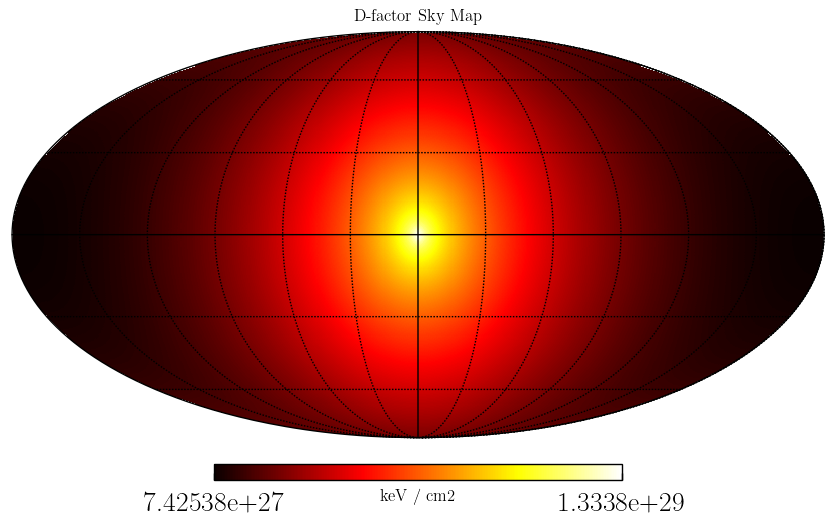

<Figure size 1000x800 with 0 Axes>

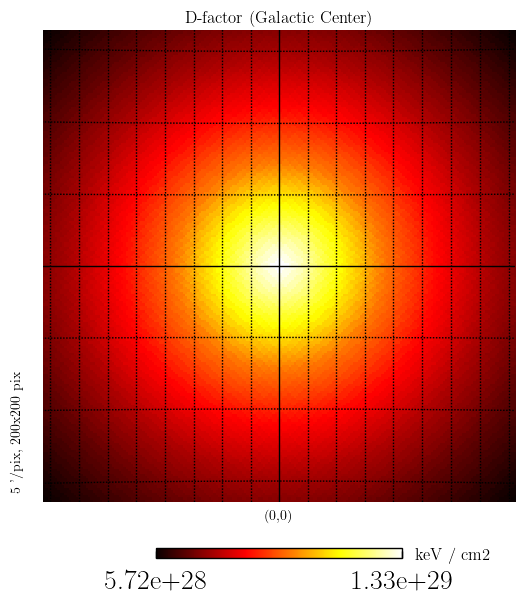

HEALPix NSIDE: 256
Number of pixels: 786432
Pixel size: 13.74 arcmin
Max D-factor: 1.334e+29 keV / cm2
Min D-factor: 7.425e+27 keV / cm2


In [13]:
# Define HEALPix resolution
nside = 256  # Higher values give finer resolution (must be power of 2)
npix = hp.nside2npix(nside)

# Get all pixel directions in Galactic coordinates
# hp.pix2vec returns unit vectors for each pixel
pixel_vectors = hp.pix2vec(nside, np.arange(npix))

# Sun is at (l, b) = (0, 0) looking toward GC at l=0, b=0
# Galactic center direction vector (from Sun's perspective)
gc_direction = np.array([1, 0, 0])  # pointing toward GC in Galactic coords

# Compute angle between each pixel and Galactic center
# Using dot product: cos(ψ) = pixel_vec · gc_vec
cos_psi = pixel_vectors[0] * gc_direction[0] + \
          pixel_vectors[1] * gc_direction[1] + \
          pixel_vectors[2] * gc_direction[2]

angles_psi = np.arccos(np.clip(cos_psi, -1, 1))  # Clip to avoid numerical errors

# Interpolate D-factors for each pixel angle
from scipy.interpolate import interp1d
D_interp = interp1d(angles_rad, D_factors.value, kind='linear', 
                    bounds_error=False, fill_value='extrapolate')

# Create HEALPix map
D_map = D_interp(angles_psi) * D_factors.unit

# Visualize the map
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
hp.mollview(D_map.value, title='D-factor Sky Map', 
            unit=f'{D_factors.unit}', 
            cmap='hot', norm='log',
            min=np.min(D_map.value[D_map.value > 0]),
            max=np.max(D_map.value))
hp.graticule()
plt.show()

# Alternative: Gnomonic projection centered on Galactic center
plt.figure(figsize=(10, 8))
hp.gnomview(D_map.value, title='D-factor (Galactic Center)', 
            unit=f'{D_factors.unit}',
            cmap='hot', norm='log',
            rot=[0, 0, 0],  # Centered on GC (l=0, b=0)
            reso=5.0)  # Resolution in arcmin
hp.graticule()
plt.show()

print(f"HEALPix NSIDE: {nside}")
print(f"Number of pixels: {npix}")
print(f"Pixel size: {hp.nside2resol(nside, arcmin=True):.2f} arcmin")
print(f"Max D-factor: {np.max(D_map.value):.3e} {D_factors.unit}")
print(f"Min D-factor: {np.min(D_map.value):.3e} {D_factors.unit}")

In [15]:
np.savez('../data/D_factor_map', D_map=D_map.value)